# Experiments on synthetic data

Code to obtain the results in Section 4 of NeurIPS 2021 Paper6977 submission,
for the proposed Conformal RNN model. This also briefly reviews the code to run the
BJRNN baseline.

In [1]:
%load_ext autoreload

%autoreload 2

Required imports

In [2]:
import numpy as np
import pickle
import torch

from matplotlib import pyplot as plt
%matplotlib inline

from utils.train_synthetic import run_synthetic_experiments, load_synthetic_results

In [3]:
BASELINES = ['QRNN', 'DPRNN', 'CFRNN', 'CFRNN_normalised']

## Time-dependent noise profile (Figure 3, Table 2)

Training procedure for CF-RNN/MQ-RNN/DP-RNN baselines (for 5 different seeds):

In [14]:
for baseline in ['CFRNN_normalised']:
    for seed in range(1):
        run_synthetic_experiments(experiment='time_dependent', 
                                  baseline=baseline,
                                  retrain=True,
                                  cached_datasets=False,
                                  save_model=True, 
                                  save_results=True,
                                  rnn_mode='LSTM',
                                  seed=seed)

Training CFRNN_normalised
Training dataset 0
Epoch: 0	Normalisation loss: 1.6359372973442077
Epoch: 100	Normalisation loss: 1.2723908424377441
Epoch: 200	Normalisation loss: 1.2516960620880127
Epoch: 300	Normalisation loss: 1.2170039892196656
Epoch: 400	Normalisation loss: 1.184722626209259
Epoch: 500	Normalisation loss: 1.1584922432899476
Epoch: 600	Normalisation loss: 1.1374752700328827
Epoch: 700	Normalisation loss: 1.1189534366130829
Epoch: 800	Normalisation loss: 1.0971182823181151
Epoch: 900	Normalisation loss: 1.0757525384426116
Training dataset 1
Epoch: 0	Normalisation loss: 1.9092247009277343
Epoch: 100	Normalisation loss: 1.3015767097473145
Epoch: 200	Normalisation loss: 1.287161922454834
Epoch: 300	Normalisation loss: 1.2733166217803955
Epoch: 400	Normalisation loss: 1.257886528968811
Epoch: 500	Normalisation loss: 1.2390721082687377
Epoch: 600	Normalisation loss: 1.2227744519710542
Epoch: 700	Normalisation loss: 1.2071114659309388
Epoch: 800	Normalisation loss: 1.1901608943

Evaluation:

**Joint coverage**

Prints mean joint coverage across the horizon (mean±std for 5 random seeds)

In [11]:
for baseline in ['CFRNN', 'CFRNN_normalised']:
    print(baseline)
    coverages = []
    for seed in range(5):
        c =[]
        results = load_synthetic_results(experiment='time_dependent', baseline=baseline, seed=seed)
        for result in results: # for each setting
            c.append(result['Mean joint coverage'] * 100)
        coverages.append(c)
    coverages = np.array(coverages)
    for m, s in zip(coverages.mean(axis=0), coverages.std(axis=0)):
        print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))
    print()

CFRNN
92.7 \(\pm\) 1.3\%
92.4 \(\pm\) 0.9\%
90.9 \(\pm\) 1.3\%
90.6 \(\pm\) 1.2\%
91.1 \(\pm\) 0.7\%

CFRNN_normalised
92.0 \(\pm\) 1.6\%
92.3 \(\pm\) 0.8\%
91.2 \(\pm\) 0.9\%
90.8 \(\pm\) 2.0\%
91.2 \(\pm\) 1.3\%



**Independent coverage**

Prints baseline and mean independent coverages across the horizon as well as their range for each of the 5 random seeds

In [29]:
for baseline in ['CFRNN_normalised']:
    print(baseline)
    for seed in range(1):
        results = load_synthetic_results(experiment='time_dependent', baseline=baseline, seed=seed)
        for result in results: # for each setting
            independent_coverages = result['Mean independent coverage']
            print(independent_coverages)
            print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

CFRNN_normalised
tensor([0.9860, 0.9800, 0.9700, 0.9780, 0.9780])
[97.0\%, 98.6\%]
tensor([0.9780, 0.9740, 0.9980, 0.9820, 0.9820])
[97.4\%, 99.8\%]
tensor([0.9760, 0.9800, 0.9740, 0.9840, 0.9660])
[96.6\%, 98.4\%]
tensor([0.9840, 0.9680, 0.9800, 0.9900, 0.9820])
[96.8\%, 99.0\%]
tensor([0.9800, 0.9800, 0.9840, 0.9780, 0.9840])
[97.8\%, 98.4\%]



**Interval widths**

Prints the baseline; mean±std of interval width across horizons; rows denote the noise configuration and columns the random seed. 

In [16]:
for baseline in ['CFRNN', 'CFRNN_normalised']:
    print(baseline)
    wws = [] # array containing interval widths for horizon=5 for each seed 
    for seed in range(5):
        ws = []
        results = load_synthetic_results(experiment='time_dependent', baseline=baseline, seed=seed)
        for result in results: # for each setting
            # for the data setttings (increasing time-dependent noise)
            widths = result['Mean confidence interval widths'] # [1xhorizon]
            # averages across the horizon, elements of ws represent different experiment mode
            ws.append('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
        wws.append(ws)

    # rows denote increasing time-dependent noise configuration, columns denote seeds
    for i in range(1): # for dataset setting
#         print('{} & {} & {} & {} & {}'.format(wws[0][i], wws[1][i], wws[2][i], wws[3][i], wws[4][i]))
        for j in range(5): # for seed
            print(wws[j][i])
    print()

CFRNN
20.10 \(\pm\) 4.22
20.52 \(\pm\) 4.43
19.87 \(\pm\) 4.17
19.24 \(\pm\) 3.81
19.26 \(\pm\) 3.24

CFRNN_normalised
24.80 \(\pm\) 6.19
20.32 \(\pm\) 4.21
20.31 \(\pm\) 4.70
19.42 \(\pm\) 3.99
19.27 \(\pm\) 3.48



In [19]:
for result in all_baselines_for_seed[baseline]:
    widths = result['Mean confidence interval widths']
    print(widths)
    break

[3.4072824 3.1347034 3.0461428 2.8346035 2.5584583]


## Static noise, no periodic component (Table ?)

## Periodic component (Figure ?)

## Plotting

In [5]:
def plot_timeseries(experiment, baseline, seed=0, index=None, forecast_only=False, figsize=(28,4), figure_name=None):
     
    plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    plt.rcParams.update({'axes.titlesize': 16,
                         'axes.labelsize': 13})
    
    datasets = []
    for i in ([2, 10] if experiment == 'periodic' else range(1, 6)):
        with open('processed_data/synthetic-{}-{}-{}.pkl'.format(experiment, i, seed), 'rb') as f:
            datasets.append(pickle.load(f))
        
    with open('saved_results/{}-{}-{}.pkl'.format(experiment, baseline, seed), 'rb') as f:
        all_results = pickle.load(f)
        
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=figsize, sharey=True)

    for j, ax in enumerate(axs.flat):
        _, dataset = datasets[j]
        results = all_results[j]
        
        X, Y, _ = dataset
            
        if index is None:
            index = range(len(X))
        i = np.random.choice(index)

        
        # Derive unpadded sequences and targets
        sequence, target = X[i], Y[i]
        
        horizon = len(target)
        length = len(sequence)
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        upper_limit = results['Upper limit']
        lower_limit = results['Lower limit']
        
        lower = [sequence[-1].item()] + lower_limit[i].flatten().tolist()
        upper = [sequence[-1].item()] + upper_limit[i].flatten().tolist()
        preds = [sequence[-1].item()] + results['Point predictions'][i].flatten().tolist()

        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), preds, linestyle="--", linewidth=3, color="r")

        if j == 0:
            ax.set(ylabel='Prediction')  
        ax.set(xlabel='Time step')
        if experiment == 'time_dependent':
            ax.set(title='$\sigma_t^2 =${:.1f}$t$'.format((j+1)*0.1))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.4)
    
    if figure_name is not None:
        plt.savefig('{}.png'.format(figure_name) , bbox_inches='tight')
    plt.show()
    
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({'axes.labelsize': 12,
                     'axes.titlesize': 12})

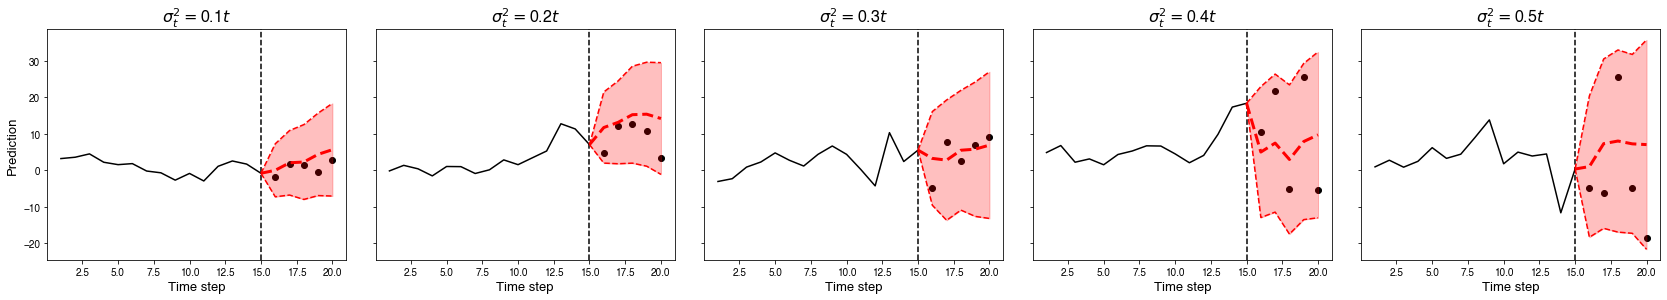

In [6]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN', index=range(5, 6), figure_name='cfrnn')

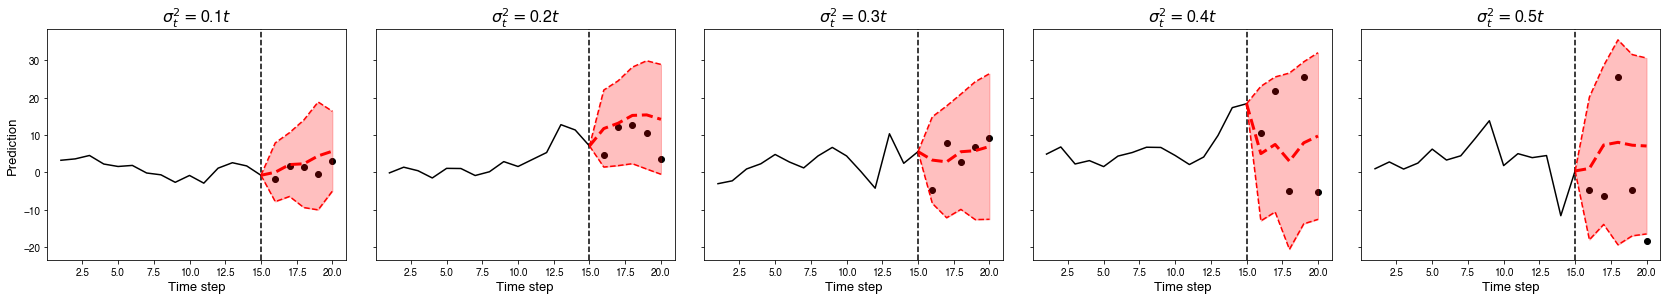

In [13]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN_normalised', index=range(5, 6), figure_name='cfrnn_n')

beta=1

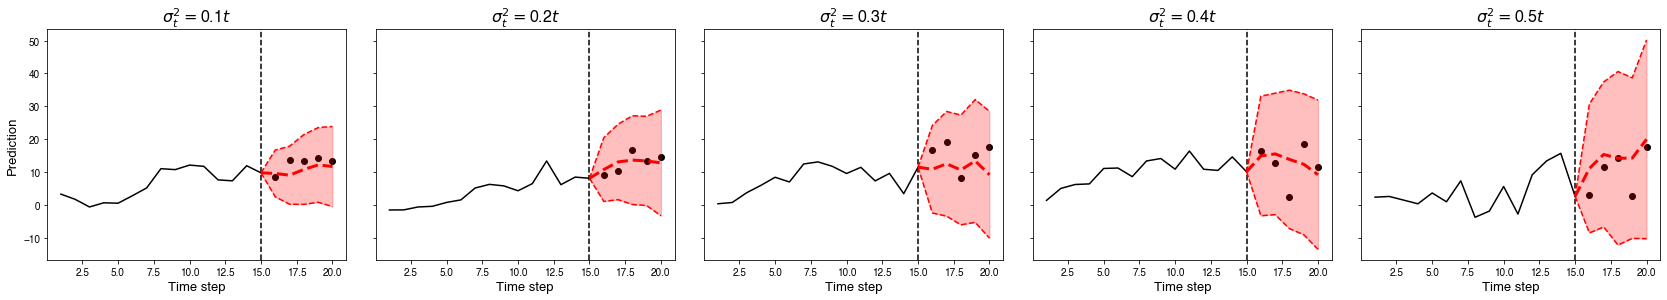

In [13]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN_normalised')

beta=5

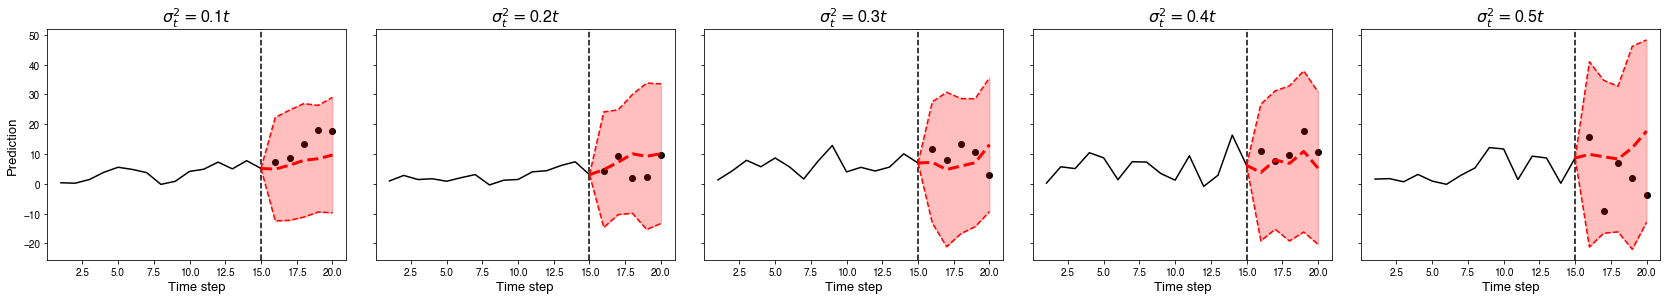

In [5]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN_normalised')

beta=10

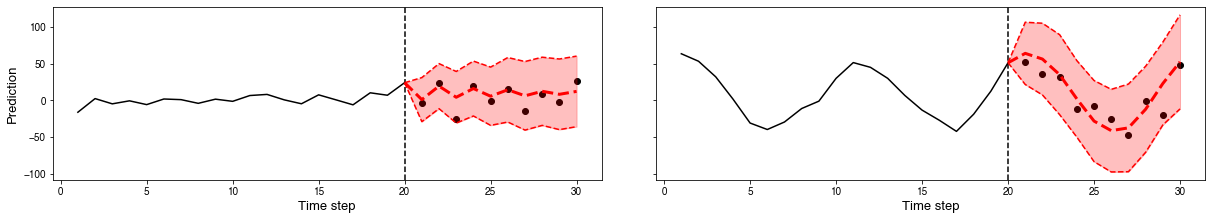

In [36]:
plot_timeseries(noise_mode='periodic', baseline='CPRNN', figsize=(20,3), figure_name='periodic')

## Long horizon analysis (Figure 4)

Training code for the three underlying RNN models:

In [ ]:
from utils.train_synthetic import run_synthetic_experiments
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='GRU')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='RNN')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='LSTM')

Analyzing interval widths:

In [ ]:
import torch
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/long-horizon_CPRNN_{}_100.pt'.format(rnn_model))
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [ ]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

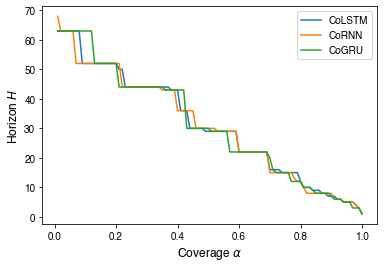

In [132]:
for threshold_width in [16]:
    valid_horizons = compute_valid_horizons(threshold_width)
    for rnn_model in valid_horizons.keys():
        plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $1-\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.savefig('{}.png'.format('tradeoff') , bbox_inches='tight', dpi=1000)
plt.show()

## BJRNN baseline

Example for training the time-dependent noise profile, for a single seed.

In [ ]:
from utils.train_synthetic import train_bjrnn
results = train_bjrnn(noise_mode='time-dependent')